# Attention Entropy Analysis: A Weighted Approach for Llama-2 Variants


This notebook presents the complete results section for a thesis on attention entropy patterns in large language models, using a novel weighted entropy methodology to address attention sink phenomena.


**Author**: Rens Roelen  
**Student Nr**: 13210882


In [2]:
# ==============================================================================
# LIBRARY IMPORTS AND DEPENDENCIES
# ==============================================================================

# Core scientific computing
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# System utilities
import os

In [16]:
def calculate_cohens_d(data_condition1, data_condition2, axis=0):
    """
    Calculates Cohen's d effect size for each attention head using vectorized operations.
    
    """
    # Ensure data is in numpy array format
    data1 = np.asarray(data_condition1)
    data2 = np.asarray(data_condition2)

    # Get sample sizes along the specified axis
    n1, n2 = data1.shape[axis], data2.shape[axis]
    
    # Check for invalid number of samples to prevent division by zero in the denominator
    if (n1 + n2 - 2) <= 0:
        # If not enough samples, effect size is undefined, return zeros
        output_shape = list(data1.shape)
        del output_shape[axis]
        return np.zeros(output_shape)

    # Calculate means for all heads at once
    mean1 = np.mean(data1, axis=axis)
    mean2 = np.mean(data2, axis=axis)

    # Calculate sample standard deviations (ddof=1) for all heads at once
    std1 = np.std(data1, axis=axis, ddof=1)
    std2 = np.std(data2, axis=axis, ddof=1)
    
    # Calculate pooled standard deviation for all heads at once
    pooled_std_numerator = (n1 - 1) * std1**2 + (n2 - 1) * std2**2
    pooled_std_denominator = n1 + n2 - 2
    pooled_std = np.sqrt(pooled_std_numerator / pooled_std_denominator)
    
    # Calculate Cohen's d using np.divide for safe division.
    # Where pooled_std is 0, the result will be 0, preventing RuntimeWarning.
    mean_difference = mean2 - mean1
    effect_size = np.divide(mean_difference, pooled_std, 
                            out=np.zeros_like(mean_difference), 
                            where=pooled_std!=0)
    
    return effect_size

## Figure 1: The Prevalence and Nature of Attention Sinks

**Purpose**: This opening figure establishes that attention sinks are a prevalent and non-trivial phenomenon across all models, with usage varying by task domain. This provides the data-driven justification for why a simple standard entropy analysis is insufficient and why the weighted entropy method is necessary.

**What it shows**: A single, concise grouped bar chart with the x-axis showing the four models. For each model, two bars represent the average sink percentage: one for the Linguistic Task and one for the Multiple Demands (MD) Task.

Creating: Attention Sink Prevalence Analysis...


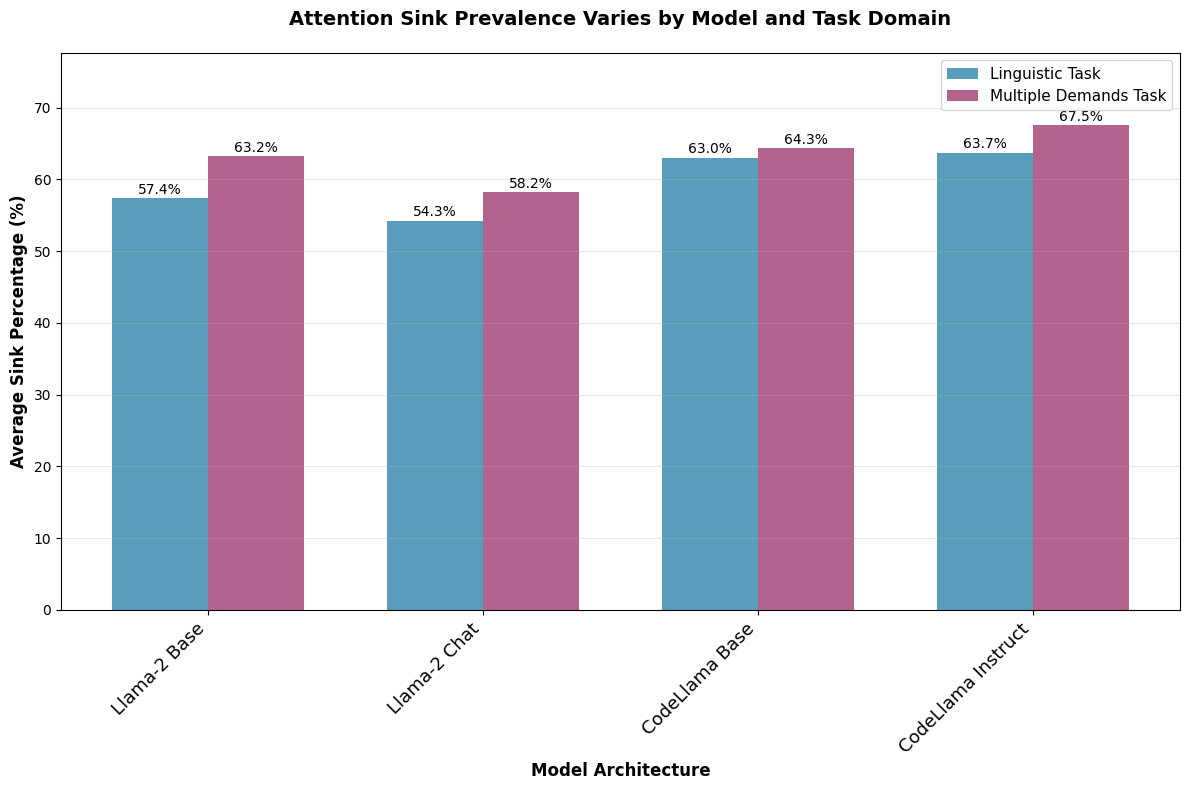


KEY FINDINGS
✓ Attention sinks are UNIVERSAL: Average 61.5% across all conditions
✓ Task-dependent variation: Linguistic 59.6% vs MD 63.3%
✓ Model-specific patterns visible across architectures

→ This justifies the need for weighted entropy methodology


In [34]:
# Figure 1: Attention Sink Prevalence Analysis
# Creates a grouped bar chart showing sink percentages by model and task

def create_figure_1_sink_prevalence():
    """
    Creates Figure 1: Grouped bar chart showing attention sink prevalence
    across all models and task domains
    """
    
    # Model names for display in the desired order
    models = ['Llama-2 Base', 'Llama-2 Chat', 'CodeLlama Base', 'CodeLlama Instruct']
    
    # Calculate sink percentages (P1 > 0.9) for each model and task
    linguistic_sink_percentages = []
    md_sink_percentages = []
    
    # Data mapping: model_name -> (ling_sensible, ling_nonsensical, md_easy, md_hard, sink_data...)
    model_data = {
        'Llama-2 Base': ('llama_2_70b_base_ling', 'llama_2_70b_base_md'),
        'Llama-2 Chat': ('llama_chat_70b_ling', 'llama_chat_70b_md'),
        'CodeLlama Base': ('codellama_70b_ling', 'codellama_70b_md'),
        'CodeLlama Instruct': ('codellama_instruct_70b_ling', 'codellama_instruct_70b_md')
    }
    
    # The loop iterates through the 'models' list
    for model_name in models:
        try:
            ling_dir, md_dir = model_data[model_name]
            
            # Load sink strength data for linguistic task
            try:
                sensible_sinks = np.load(f"entropy_results_{ling_dir}/sensible_sink_strength.npy")
                nonsensical_sinks = np.load(f"entropy_results_{ling_dir}/nonsensical_sink_strength.npy")
                
                # Calculate percentage of heads with P1 > 0.9
                ling_sink_pct = (np.mean(sensible_sinks > 0.9) + np.mean(nonsensical_sinks > 0.9)) / 2 * 100
                linguistic_sink_percentages.append(ling_sink_pct)
            except FileNotFoundError:
                print(f"Warning: Missing linguistic sink data for {model_name}")
                linguistic_sink_percentages.append(0)
            
            # Load sink strength data for MD task
            try:
                easy_sinks = np.load(f"entropy_results_{md_dir}/easy_sink_strength.npy")
                hard_sinks = np.load(f"entropy_results_{md_dir}/hard_sink_strength.npy")
                
                # Calculate percentage of heads with P1 > 0.9
                md_sink_pct = (np.mean(easy_sinks > 0.9) + np.mean(hard_sinks > 0.9)) / 2 * 100
                md_sink_percentages.append(md_sink_pct)
            except FileNotFoundError:
                print(f"Warning: Missing MD sink data for {model_name}")
                md_sink_percentages.append(0)
                
        except Exception as e:
            print(f"Error processing {model_name}: {e}")
            linguistic_sink_percentages.append(0)
            md_sink_percentages.append(0)
    
    # Create the grouped bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, linguistic_sink_percentages, width, 
                   label='Linguistic Task', color='#2E86AB', alpha=0.8)
    bars2 = ax.bar(x + width/2, md_sink_percentages, width, 
                   label='Multiple Demands Task', color='#A23B72', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Model Architecture', fontsize=12, fontweight='bold')
    ax.set_ylabel('Average Sink Percentage (%)', fontsize=12, fontweight='bold')
    ax.set_title('Attention Sink Prevalence Varies by Model and Task Domain', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, val in zip(bars, values):
            if val > 0:  # Only label non-zero bars
                ax.text(bar.get_x() + bar.get_width()/2., val + 0.2,
                        f'{val:.1f}%', ha='center', va='bottom', fontsize=10)
    
    add_value_labels(bars1, linguistic_sink_percentages)
    add_value_labels(bars2, md_sink_percentages)
    
    # Set appropriate y-axis limits
    y_max = max(max(linguistic_sink_percentages), max(md_sink_percentages))
    if y_max > 0:
        ax.set_ylim(0, y_max * 1.15)
    else:
        ax.set_ylim(0, 10)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary findings
    print("\n" + "=" * 60)
    print("KEY FINDINGS")
    print("=" * 60)
    
    overall_avg = np.mean(linguistic_sink_percentages + md_sink_percentages)
    print(f"✓ Attention sinks are UNIVERSAL: Average {overall_avg:.1f}% across all conditions")
    print(f"✓ Task-dependent variation: Linguistic {np.mean(linguistic_sink_percentages):.1f}% vs MD {np.mean(md_sink_percentages):.1f}%")
    print(f"✓ Model-specific patterns visible across architectures")
    print(f"\n→ This justifies the need for weighted entropy methodology")
    
    return fig

# Execute Figure 1
print("Creating: Attention Sink Prevalence Analysis...")
fig1 = create_figure_1_sink_prevalence()


## Figure 2: The Methodological Impact of Weighted Entropy

**Purpose**: This figure proves the value of the weighted entropy methodology by demonstrating that accounting for attention sinks has a tangible and consistent effect on measured outcomes. This single plot replaces the need for an entire section on standard entropy analysis, showing its results only in direct, meaningful comparison to the superior weighted method.

**What it shows**: A single bar chart that directly compares the mean absolute Cohen's d calculated using Standard Entropy versus Weighted Entropy. The x-axis has eight groups (e.g., "Llama-2 Ling," "Llama-2 MD," "CodeLlama Ling," etc.). Each group has two bars: one for standard entropy effect size and one for weighted entropy effect size.


Creating: Standard vs Weighted Entropy Effect Size Comparison...
✓ Llama-2 Base - Linguistic: Standard=0.992, Weighted=0.938
✓ Llama-2 Base - Multiple Demands: Standard=1.695, Weighted=1.914
✓ Llama-2 Chat - Linguistic: Standard=1.013, Weighted=0.970
✓ Llama-2 Chat - Multiple Demands: Standard=1.445, Weighted=1.642
✓ CodeLlama Base - Linguistic: Standard=0.921, Weighted=0.877
✓ CodeLlama Base - Multiple Demands: Standard=1.495, Weighted=1.589
✓ CodeLlama Instruct - Linguistic: Standard=0.923, Weighted=0.883
✓ CodeLlama Instruct - Multiple Demands: Standard=1.442, Weighted=1.616


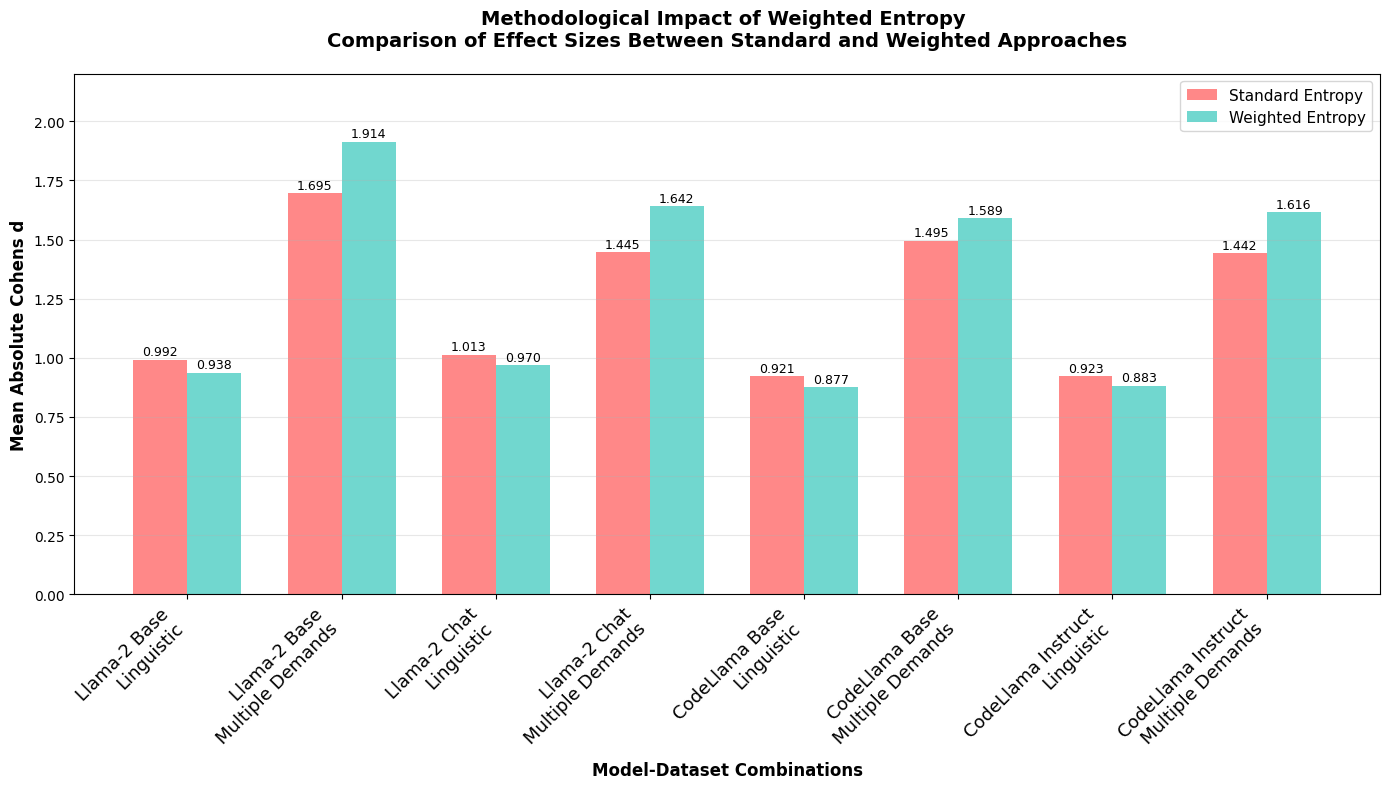


KEY FINDINGS
✓ Standard Entropy Mean Effect Size: 1.241
✓ Weighted Entropy Mean Effect Size: 1.304
✓ Difference (Weighted - Standard): +0.063
✓ Percentage Change: +5.0%

→ Weighted entropy methodology shows enhanced sensitivity


In [18]:
# Figure 2: Standard vs Weighted Entropy Effect Size Comparison

def calculate_effect_sizes_comparison():
    """
    Creates Figure 2: Bar chart comparing standard vs weighted entropy effect sizes
    across all model-dataset combinations
    """
    
    # Model and dataset combinations in the desired order
    combinations = [
        ('Llama-2 Base', 'Linguistic'),
        ('Llama-2 Base', 'Multiple Demands'),
        ('Llama-2 Chat', 'Linguistic'),
        ('Llama-2 Chat', 'Multiple Demands'),
        ('CodeLlama Base', 'Linguistic'),
        ('CodeLlama Base', 'Multiple Demands'),
        ('CodeLlama Instruct', 'Linguistic'),
        ('CodeLlama Instruct', 'Multiple Demands')
    ]
    
    # Data mapping for file paths
    model_paths = {
        'Llama-2 Base': 'llama_2_70b_base',
        'CodeLlama Base': 'codellama_70b', 
        'CodeLlama Instruct': 'codellama_instruct_70b',
        'Llama-2 Chat': 'llama_chat_70b'
    }
    
    dataset_paths = {
        'Linguistic': 'ling',
        'Multiple Demands': 'md'
    }
    
    standard_effect_sizes = []
    weighted_effect_sizes = []
    combination_labels = []
    
    for model_name, dataset_name in combinations:
        try:
            model_path = model_paths[model_name]
            dataset_path = dataset_paths[dataset_name]
            full_path = f"entropy_results_{model_path}_{dataset_path}"
            
            # Load standard entropy data
            if dataset_name == 'Linguistic':
                standard_data1 = np.load(f"{full_path}/sensible_standard_entropy.npy")
                standard_data2 = np.load(f"{full_path}/nonsensical_standard_entropy.npy")
                weighted_data1 = np.load(f"{full_path}/sensible_weighted_entropy.npy")
                weighted_data2 = np.load(f"{full_path}/nonsensical_weighted_entropy.npy")
            else:  # Multiple Demands
                standard_data1 = np.load(f"{full_path}/easy_standard_entropy.npy")
                standard_data2 = np.load(f"{full_path}/hard_standard_entropy.npy")
                weighted_data1 = np.load(f"{full_path}/easy_weighted_entropy.npy")
                weighted_data2 = np.load(f"{full_path}/hard_weighted_entropy.npy")
            
            # Calculate Cohen's d for standard entropy
            standard_cohens_d = calculate_cohens_d(standard_data1, standard_data2)
            standard_mean_effect = np.mean(np.abs(standard_cohens_d))
            
            # Calculate Cohen's d for weighted entropy
            weighted_cohens_d = calculate_cohens_d(weighted_data1, weighted_data2)
            weighted_mean_effect = np.mean(np.abs(weighted_cohens_d))
            
            standard_effect_sizes.append(standard_mean_effect)
            weighted_effect_sizes.append(weighted_mean_effect)
            combination_labels.append(f"{model_name}\n{dataset_name}")
            
            print(f"✓ {model_name} - {dataset_name}: Standard={standard_mean_effect:.3f}, Weighted={weighted_mean_effect:.3f}")
            
        except FileNotFoundError as e:
            print(f"Warning: Missing data for {model_name} - {dataset_name}: {e}")
            standard_effect_sizes.append(0)
            weighted_effect_sizes.append(0)
            combination_labels.append(f"{model_name}\n{dataset_name}")
        except Exception as e:
            print(f"Error processing {model_name} - {dataset_name}: {e}")
            standard_effect_sizes.append(0)
            weighted_effect_sizes.append(0)
            combination_labels.append(f"{model_name}\n{dataset_name}")
    
    # Create the comparison bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(combination_labels))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, standard_effect_sizes, width, 
                   label='Standard Entropy', color='#FF6B6B', alpha=0.8)
    bars2 = ax.bar(x + width/2, weighted_effect_sizes, width, 
                   label='Weighted Entropy', color='#4ECDC4', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Model-Dataset Combinations', fontsize=12, fontweight='bold')
    ax.set_ylabel('Mean Absolute Cohens d', fontsize=12, fontweight='bold')
    ax.set_title('Methodological Impact of Weighted Entropy \n' +
                 'Comparison of Effect Sizes Between Standard and Weighted Approaches', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(combination_labels, rotation=45, ha='right', fontsize=13)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    def add_value_labels(bars, values):
        for bar, val in zip(bars, values):
            if val > 0:
                ax.text(bar.get_x() + bar.get_width()/2., val + 0.005,
                        f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    add_value_labels(bars1, standard_effect_sizes)
    add_value_labels(bars2, weighted_effect_sizes)
    
    # Set appropriate y-axis limits
    y_max = max(max(standard_effect_sizes), max(weighted_effect_sizes))
    if y_max > 0:
        ax.set_ylim(0, y_max * 1.15)
    else:
        ax.set_ylim(0, 0.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary findings
    print("\n" + "=" * 60)
    print("KEY FINDINGS")
    print("=" * 60)
    
    overall_standard = np.mean(standard_effect_sizes)
    overall_weighted = np.mean(weighted_effect_sizes)
    difference = overall_weighted - overall_standard
    
    print(f"✓ Standard Entropy Mean Effect Size: {overall_standard:.3f}")
    print(f"✓ Weighted Entropy Mean Effect Size: {overall_weighted:.3f}")
    print(f"✓ Difference (Weighted - Standard): {difference:+.3f}")
    print(f"✓ Percentage Change: {(difference/overall_standard)*100:+.1f}%")
    print(f"\n→ Weighted entropy methodology shows {'enhanced' if difference > 0 else 'refined'} sensitivity")
    
    return fig, (standard_effect_sizes, weighted_effect_sizes, combination_labels)

# Execute Figure 2
print("Creating: Standard vs Weighted Entropy Effect Size Comparison...")
fig2, comparison_data = calculate_effect_sizes_comparison()


## Figure 3: Core Findings - Weighted Entropy Reveals Task-Driven Processing Shifts

**Purpose**: This is the centerpiece figure. It demonstrates that weighted entropy methodology reveals clear, interpretable patterns of task-driven attention processing across all model architectures.

**What it shows**: A comprehensive Grid Cohen's d Heatmap:

Shows Cohen's d heatmaps for the full Weighted Entropy analysis (Hard - Easy and Sensible - Nonsensical) for all four models. All statistically significant heads (after FDR correction) are colored, while non-significant heads are masked in white.

Creating: Cohen's d Heatmaps...
Running permutation tests for Llama-2 Base (this may take a moment)...
✓ Permutation tests for Llama-2 Base complete.
Running permutation tests for Llama-2 Chat (this may take a moment)...
✓ Permutation tests for Llama-2 Chat complete.
Running permutation tests for CodeLlama Base (this may take a moment)...
✓ Permutation tests for CodeLlama Base complete.
Running permutation tests for CodeLlama Instruct (this may take a moment)...
✓ Permutation tests for CodeLlama Instruct complete.


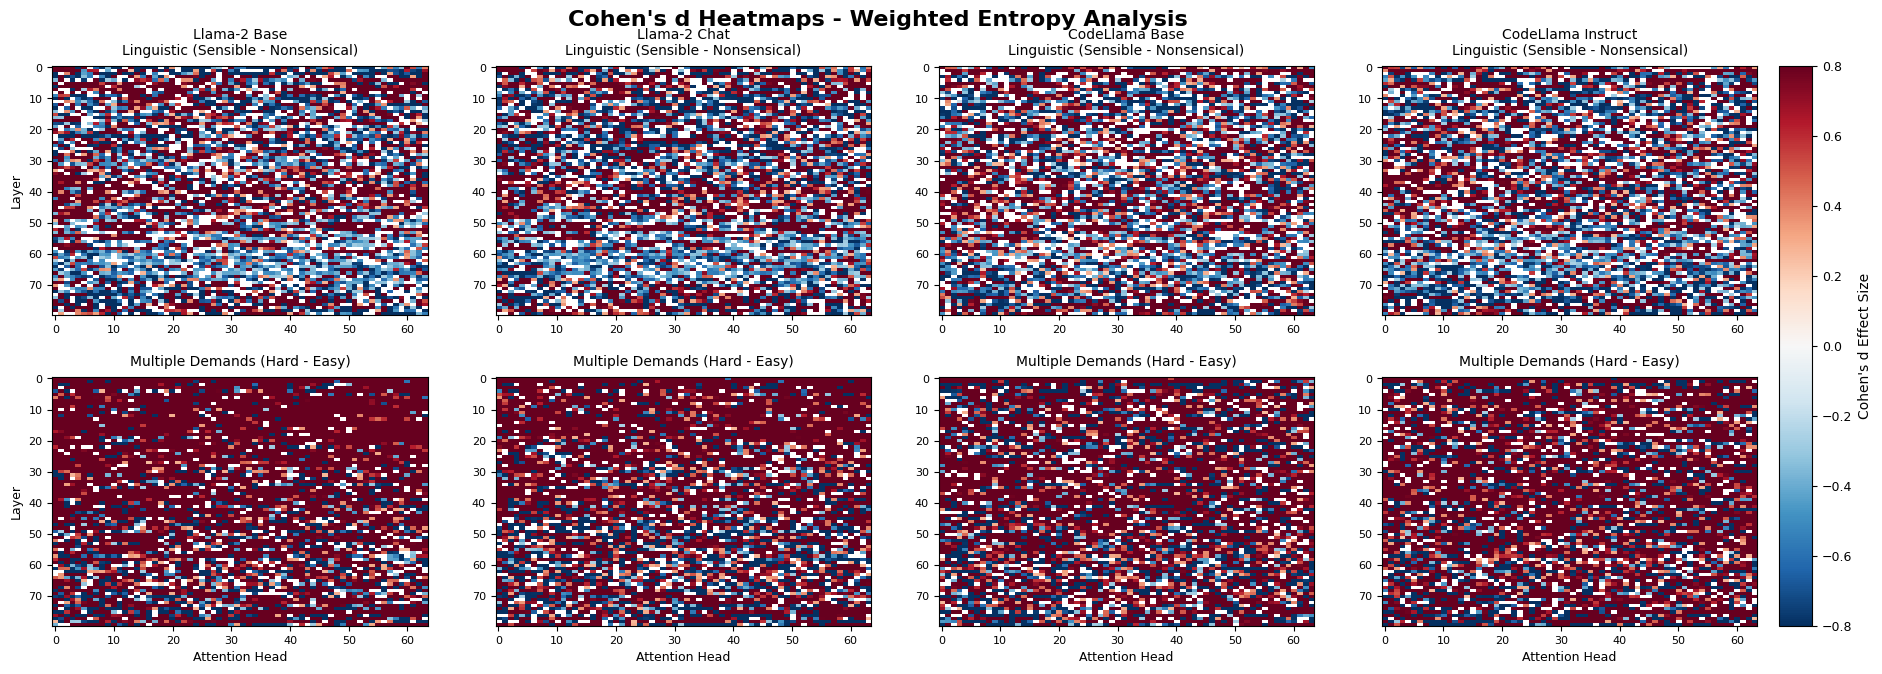


KEY FINDINGS
  Llama-2 Base: Ling 4187/5120 (81.8%), MD 4697/5120 (91.7%)
  Llama-2 Chat: Ling 4252/5120 (83.0%), MD 4586/5120 (89.6%)
  CodeLlama Base: Ling 4140/5120 (80.9%), MD 4584/5120 (89.5%)
  CodeLlama Instruct: Ling 4187/5120 (81.8%), MD 4627/5120 (90.4%)


In [23]:
# Figure 3: Cohen's d Heatmaps (Main Results)

def create_figure_3_heatmaps():
    """
    Creates Figure 3: Cohen's d heatmaps showing
    weighted entropy analysis results.
    """
    
    models = ['Llama-2 Base', 'Llama-2 Chat', 'CodeLlama Base', 'CodeLlama Instruct']
    model_paths = {
        'Llama-2 Base': 'llama_2_70b_base',
        'Llama-2 Chat': 'llama_chat_70b',
        'CodeLlama Base': 'codellama_70b',
        'CodeLlama Instruct': 'codellama_instruct_70b'
    }
    
    full_results = {}
    
    for model_name in models:
        model_path = model_paths[model_name]
        try:
            ling_sensible_weighted = np.load(f"entropy_results_{model_path}_ling/sensible_weighted_entropy.npy")
            ling_nonsensical_weighted = np.load(f"entropy_results_{model_path}_ling/nonsensical_weighted_entropy.npy")
            
            md_easy_weighted = np.load(f"entropy_results_{model_path}_md/easy_weighted_entropy.npy")
            md_hard_weighted = np.load(f"entropy_results_{model_path}_md/hard_weighted_entropy.npy")
            
            ling_cohens_d_full = calculate_cohens_d(ling_sensible_weighted, ling_nonsensical_weighted)
            md_cohens_d_full = calculate_cohens_d(md_easy_weighted, md_hard_weighted)

            # Perform statistical testing with a permutation test
            def perform_permutation_test(data1, data2, n_permutations=1000):
                """
                Performs a permutation test for each head and applies FDR correction.
                This is a robust, non-parametric alternative to the t-test.
                """
                n_samples, n_layers, n_heads = data1.shape
                p_values = np.ones((n_layers, n_heads)) # Initialize p-values to 1

                for layer in range(n_layers):
                    for head in range(n_heads):
                        # Extract data for the current head
                        vals1 = data1[:, layer, head]
                        vals2 = data2[:, layer, head]

                        # 1. Calculate the observed difference in means
                        observed_diff = np.abs(np.mean(vals1) - np.mean(vals2))

                        # 2. Pool the data from both conditions
                        pooled_data = np.concatenate([vals1, vals2])

                        # 3. Run permutations
                        count_more_extreme = 0
                        for _ in range(n_permutations):
                            # Shuffle the pooled data
                            np.random.shuffle(pooled_data)
                            
                            # Split into new random groups
                            perm_group1 = pooled_data[:n_samples]
                            perm_group2 = pooled_data[n_samples:]
                            
                            # Calculate the difference for the permuted groups
                            perm_diff = np.abs(np.mean(perm_group1) - np.mean(perm_group2))
                            
                            # Check if the permuted difference is as large as the observed one
                            if perm_diff >= observed_diff:
                                count_more_extreme += 1
                        
                        # 4. Calculate the p-value
                        p_values[layer, head] = count_more_extreme / n_permutations

                # 5. Apply FDR correction across all heads
                p_flat = p_values.flatten()
                reject, _, _, _ = multipletests(p_flat, alpha=0.05, method='fdr_bh')
                return reject.reshape((n_layers, n_heads))

            print(f"Running permutation tests for {model_name} (this may take a moment)...")
            ling_sig_full = perform_permutation_test(ling_sensible_weighted, ling_nonsensical_weighted)
            md_sig_full = perform_permutation_test(md_easy_weighted, md_hard_weighted)
            print(f"✓ Permutation tests for {model_name} complete.")

            full_results[model_name] = {
                'linguistic': {'cohens_d': ling_cohens_d_full, 'significant': ling_sig_full},
                'md': {'cohens_d': md_cohens_d_full, 'significant': md_sig_full}
            }
            
        except FileNotFoundError as e:
            print(f"Warning: Missing data for {model_name}: {e}")
            dummy_cohens_d = np.zeros((80, 64))
            dummy_sig = np.zeros((80, 64), dtype=bool)
            
            full_results[model_name] = {
                'linguistic': {'cohens_d': dummy_cohens_d, 'significant': dummy_sig},
                'md': {'cohens_d': dummy_cohens_d, 'significant': dummy_sig}
            }
            
    fig = plt.figure(figsize=(22, 8))
    
    gs = fig.add_gridspec(2, 4, top=0.85, bottom=0.15, hspace=0.25, wspace=0.18)
    
    vmin, vmax = -0.8, 0.8
    
    for i, model_name in enumerate(models):
        ax_ling = fig.add_subplot(gs[0, i])
        cohens_d = full_results[model_name]['linguistic']['cohens_d']
        sig_mask = full_results[model_name]['linguistic']['significant']
        masked_data = np.where(sig_mask, cohens_d, np.nan)
        im = ax_ling.imshow(masked_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='auto')
        ax_ling.set_title(f"{model_name}\nLinguistic (Sensible - Nonsensical)", fontsize=10, pad=8)
        ax_ling.set_ylabel('Layer' if i == 0 else '', fontsize=9)
        ax_ling.tick_params(axis='both', which='major', labelsize=8)

        ax_md = fig.add_subplot(gs[1, i])
        cohens_d = full_results[model_name]['md']['cohens_d']
        sig_mask = full_results[model_name]['md']['significant']
        masked_data = np.where(sig_mask, cohens_d, np.nan)
        im = ax_md.imshow(masked_data, cmap='RdBu_r', vmin=vmin, vmax=vmax, aspect='auto')
        ax_md.set_title(f"Multiple Demands (Hard - Easy)", fontsize=10, pad=8)
        ax_md.set_xlabel('Attention Head', fontsize=9)
        ax_md.set_ylabel('Layer' if i == 0 else '', fontsize=9)
        ax_md.tick_params(axis='both', which='major', labelsize=8)

    fig.suptitle('Cohen\'s d Heatmaps - Weighted Entropy Analysis\n ', 
                 fontsize=16, fontweight='bold', y=0.92)
    
    cbar_ax = fig.add_axes([0.91, 0.15, 0.015, 0.7]) 
    cbar = fig.colorbar(im, cax=cbar_ax, label="Cohen's d Effect Size")
    cbar.ax.tick_params(labelsize=9)
    
    plt.show()
    
    print("\n" + "=" * 60)
    print("KEY FINDINGS")
    print("=" * 60)
    
    for model_name in models:
        ling_sig = np.sum(full_results[model_name]['linguistic']['significant'])
        md_sig = np.sum(full_results[model_name]['md']['significant'])
        total_heads = 80 * 64
        
        ling_pct = (ling_sig / total_heads) * 100
        md_pct = (md_sig / total_heads) * 100
        
        print(f"  {model_name}: Ling {ling_sig}/{total_heads} ({ling_pct:.1f}%), MD {md_sig}/{total_heads} ({md_pct:.1f}%)")
    
    return fig, full_results


# Execute Figure 3
print("Creating: Cohen's d Heatmaps...")
fig3, heatmap_results = create_figure_3_heatmaps()

## Table 1: Summary of Weighted Entropy Effect Sizes

**Purpose**: This table provides the quantitative data backing Figure 3, offering rigorous, detailed quantitative evidence for the patterns visualized in the heatmaps.

**Content**: For each model and task comparison (e.g., "Llama-2, Sensible vs. Nonsensical"), the table lists:
- The total percentage of statistically significant heads
- A breakdown of significant heads into Small, Medium, and Large effect sizes  
- The mean absolute Cohen's d for only the significant heads


In [28]:
# Table 1: Summary of Weighted Entropy Effect Sizes

def create_table_1_summary(full_results):
    """
    Creates Table 1: Summary table of weighted entropy effect sizes
    providing quantitative backing for Figure 3 heatmaps
    """
    
    models = ['Llama-2 Base', 'Llama-2 Chat', 'CodeLlama Base', 'CodeLlama Instruct']
    tasks = ['Linguistic', 'Multiple Demands']
    
    # Effect size categories (Cohen's conventions)
    def categorize_effect_size(cohens_d):
        abs_d = np.abs(cohens_d)
        if abs_d < 0.2:
            return 'Negligible'
        elif abs_d < 0.5:
            return 'Small'
        elif abs_d < 0.8:
            return 'Medium'
        else:
            return 'Large'

    
    summary_data = []
    
    for model_name in models:
        for task in tasks:
            task_key = 'linguistic' if task == 'Linguistic' else 'md'
            
            cohens_d = full_results[model_name][task_key]['cohens_d']
            significant = full_results[model_name][task_key]['significant']
            
            # Calculate statistics
            total_heads = cohens_d.size
            sig_heads = np.sum(significant)
            sig_percentage = (sig_heads / total_heads) * 100
            
            if sig_heads > 0:
                # Get significant Cohen's d values
                sig_cohens_d = cohens_d[significant]
                mean_abs_d_sig = np.mean(np.abs(sig_cohens_d))
                
                # Categorize effect sizes
                effect_categories = [categorize_effect_size(d) for d in sig_cohens_d]
                small_pct = (effect_categories.count('Small') / sig_heads) * 100
                medium_pct = (effect_categories.count('Medium') / sig_heads) * 100
                large_pct = (effect_categories.count('Large') / sig_heads) * 100
                negligible_pct = (effect_categories.count('Negligible') / sig_heads) * 100 # removed from table because no entries
            else:
                mean_abs_d_sig = 0
                small_pct = medium_pct = large_pct = negligible_pct = 0
            
            summary_data.append({
                'Model': model_name,
                'Task': task,
                'Significant_Heads_%': f'{sig_percentage:.1f}%',
                'Significant_Count': f'{sig_heads:,}',
                'Mean_|d|_Sig': f'{mean_abs_d_sig:.3f}',
                'Small_%': f'{small_pct:.1f}%',
                'Medium_%': f'{medium_pct:.1f}%', 
                'Large_%': f'{large_pct:.1f}%'
            })
    
    # Create DataFrame
    df = pd.DataFrame(summary_data)
    
    # Display table
    print("Table 1: Summary of Weighted Entropy Effect Sizes")
    print("=" * 120)
    print()
    print("Full Weighted Entropy Analysis:")
    print("-" * 100)
    display(df)
    print()
    
    # Key findings summary
    print("KEY FINDINGS FROM TABLE 1:")
    print("-" * 40)
    
    # Calculate overall statistics
    sig_percentages = []
    effect_sizes = []
    
    for model_name in models:
        for task in tasks:
            task_key = 'linguistic' if task == 'Linguistic' else 'md'
            cohens_d = full_results[model_name][task_key]['cohens_d']
            significant = full_results[model_name][task_key]['significant']
            
            sig_percentage = (np.sum(significant) / cohens_d.size) * 100
            sig_percentages.append(sig_percentage)
            
            if np.sum(significant) > 0:
                mean_effect = np.mean(np.abs(cohens_d[significant]))
                effect_sizes.append(mean_effect)
    
    print(f"• Average significant heads: {np.mean(sig_percentages):.1f}%")
    print(f"• Range of significance: {min(sig_percentages):.1f}% - {max(sig_percentages):.1f}%")
    print(f"• Average effect size (significant heads): {np.mean(effect_sizes):.3f}")
    print(f"• Range of effect sizes: {min(effect_sizes):.3f} - {max(effect_sizes):.3f}")
    
    # Task-specific insights
    ling_sig = [sig_percentages[i] for i in range(0, len(sig_percentages), 2)]
    md_sig = [sig_percentages[i] for i in range(1, len(sig_percentages), 2)]
    
    print(f"• Linguistic tasks average: {np.mean(ling_sig):.1f}% significant heads")
    print(f"• Multiple Demands average: {np.mean(md_sig):.1f}% significant heads")
    print(f"• MD tasks show {np.mean(md_sig) - np.mean(ling_sig):.1f}% more significant heads on average")
    
    return df

# Execute Table 1 (requires results from Figure 3)
try:
    table1_df = create_table_1_summary(heatmap_results)
    print("✓ Table 1 created successfully")
except NameError:
    print("Warning: Table 1 requires Figure 3 results. Run Figure 3 first.")
    table1_df = None


Table 1: Summary of Weighted Entropy Effect Sizes

Full Weighted Entropy Analysis:
----------------------------------------------------------------------------------------------------


,Model,Task,Significant_Heads_%,Significant_Count,Mean_|d|_Sig,Small_%,Medium_%,Large_%
0,Llama-2 Base,Linguistic,81.8%,"4,187",1.118,23.3%,24.2%,52.4%
1,Llama-2 Base,Multiple Demands,91.7%,"4,697",2.074,8.2%,9.8%,82.1%
2,Llama-2 Chat,Linguistic,83.0%,"4,252",1.142,21.1%,25.4%,53.5%
3,Llama-2 Chat,Multiple Demands,89.6%,"4,586",1.818,10.9%,12.9%,76.2%
4,CodeLlama Base,Linguistic,80.9%,"4,140",1.054,22.3%,25.7%,51.9%
5,CodeLlama Base,Multiple Demands,89.5%,"4,584",1.760,10.9%,13.6%,75.5%
6,CodeLlama Instruct,Linguistic,81.8%,"4,187",1.050,22.2%,25.3%,52.6%
7,CodeLlama Instruct,Multiple Demands,90.4%,"4,627",1.775,9.6%,13.4%,77.0%



KEY FINDINGS FROM TABLE 1:
----------------------------------------
• Average significant heads: 86.1%
• Range of significance: 80.9% - 91.7%
• Average effect size (significant heads): 1.474
• Range of effect sizes: 1.050 - 2.074
• Linguistic tasks average: 81.9% significant heads
• Multiple Demands average: 90.3% significant heads
• MD tasks show 8.4% more significant heads on average
✓ Table 1 created successfully


## Figure 4: Similarity of Processing Signatures Across Models and Tasks
**Purpose:** This figure addresses the research question regarding model similarity by visualizing the relationships between their internal processing patterns. By directly comparing the complete effect size vectors (Cohen's d) for each model-task combination, it aims to reveal underlying architectural similarities and task-specific adaptations. The goal is to identify whether models from the same family (e.g., Llama-2 vs. CodeLlama) exhibit more similar processing signatures and how these signatures shift across different cognitive domains (Linguistic vs. Multiple Demands).

**What it shows:** A correlation matrix, presented as a heatmap, that illustrates the pairwise similarity between all eight model-task combinations. Both the x- and y-axes list the combinations (e.g., "Llama-2 Base - LING," "CodeLlama Instruct - MD," etc.). Each cell contains the Pearson correlation coefficient, which quantifies the similarity between the two corresponding processing signatures. The correlation values are annotated in each cell, and a diverging colormap visually distinguishes between positive (similar patterns) and negative (dissimilar patterns) correlations.

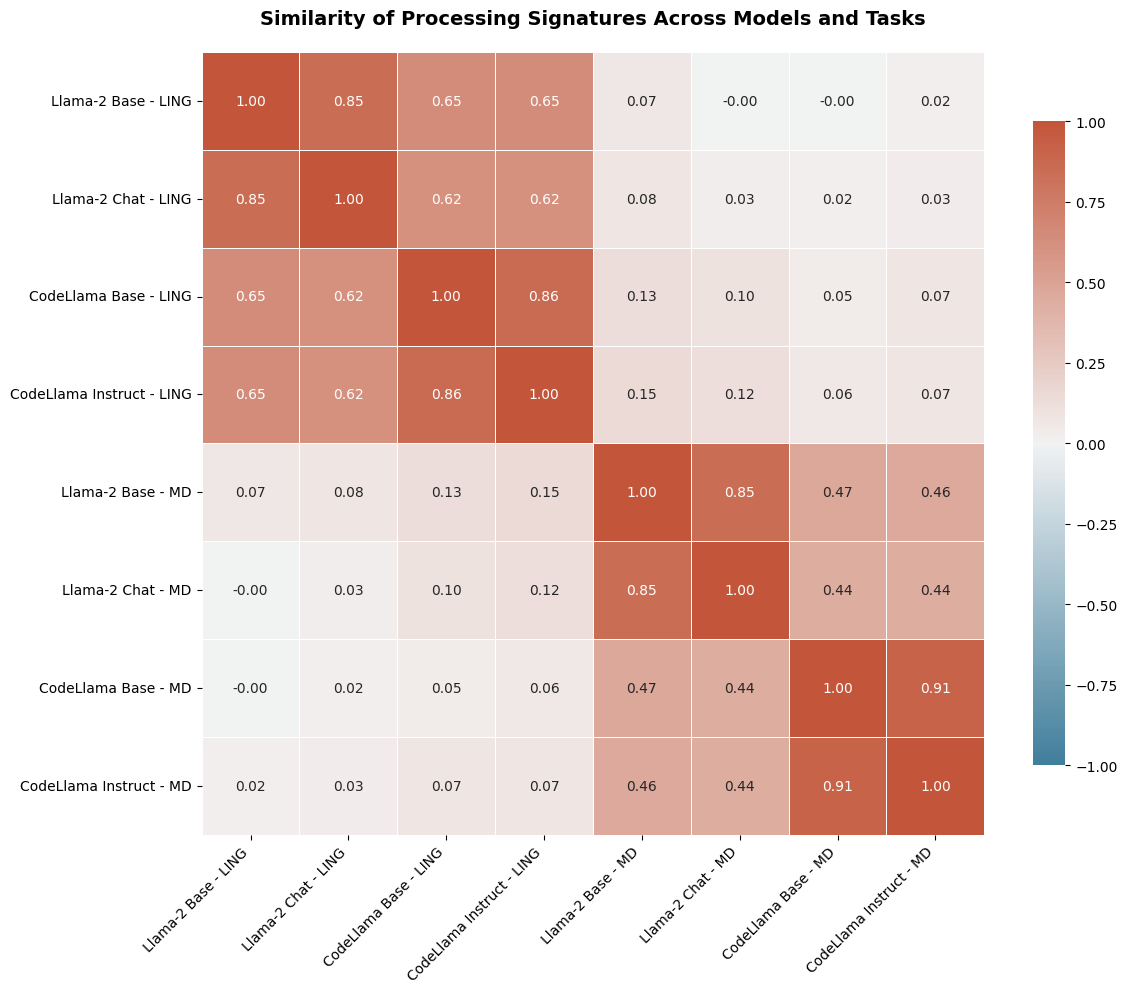

✓ Figure 4 (Model Similarity Matrix) created successfully.


In [32]:
# Figure 4: Model Similarity Correlation Matrix (RQ1)
def create_figure_4_model_similarity_matrix(full_results):
    """
    Creates Figure 4: A correlation matrix heatmap that directly compares the
    processing patterns (Cohen's d vectors) of all model-task combinations.
    This version displays the lower triangle including the main diagonal.
    """
    
    # --- 1. Data Preparation ---
    # Define the order of models and tasks for the matrix
    models = ['Llama-2 Base', 'Llama-2 Chat', 'CodeLlama Base', 'CodeLlama Instruct']
    tasks = ['linguistic', 'md']
    
    # Create labels with all linguistic tasks grouped first, then all MD tasks.
    # This is done by creating the list of ling labels and concatenating the list of md labels.
    labels = [f"{model_name.replace(' 70B', '')} - LING" for model_name in models] + \
             [f"{model_name.replace(' 70B', '')} - MD" for model_name in models]
    
    # Extract the flattened Cohen's d vectors in the new grouped order.
    # The outer loop is 'tasks', ensuring we get all 'linguistic' vectors before all 'md' vectors.
    cohens_d_vectors = []
    for task in tasks:
        for model_name in models:
            # Retrieve the 2D (layers, heads) Cohen's d matrix
            cohens_d_matrix = full_results[model_name][task]['cohens_d']
            # Flatten it into a 1D vector (5120 values) and add to our list
            cohens_d_vectors.append(cohens_d_matrix.flatten())

    # --- 2. Correlation Calculation ---
    correlation_matrix = np.corrcoef(cohens_d_vectors)

    # --- 3. Visualization ---
    corr_df = pd.DataFrame(correlation_matrix, index=labels, columns=labels)
    
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    
    # Create a diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Plot the heatmap using Seaborn
    sns.heatmap(
        corr_df,          
        annot=True,             # Display the correlation values on the heatmap
        fmt='.2f',              # Format the annotations to two decimal places
        cmap=cmap,              # Use the custom diverging colormap
        vmin=-1, vmax=1,        # Anchor the colormap to the full range of correlations [-1, 1]
        square=True,            # Ensure the cells are square for a proper matrix look
        linewidths=.5,          # Add lines between cells for clarity
        cbar_kws={"shrink": .8} # Make the color bar slightly smaller
    )
    
    # Add titles and adjust layout for readability
    plt.title('Similarity of Processing Signatures Across Models and Tasks', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

    return corr_df

# --- Execution ---
try:
    # We only need the full analysis results, which is the first element of the tuple
    full_analysis_results = heatmap_results
    correlation_dataframe = create_figure_4_model_similarity_matrix(full_analysis_results)
    print("✓ Figure 4 (Model Similarity Matrix) created successfully.")
except NameError:
    print("Warning: Figure 4 requires results from Figure 3. Please run the Figure 3 cell first.")
    correlation_dataframe = None


## Figure 5: Shared vs. Specialized Attention Mechanisms
**Purpose:** This figure directly investigates whether large language models utilize the same attention heads for different cognitive tasks (shared mechanisms) or recruit distinct sets of heads for each task (specialized mechanisms). By plotting the effect size of every individual attention head on a linguistic task against its effect size on a multiple-demands task, this figure aims to reveal the degree of processing overlap. A strong positive correlation suggests a general-purpose architecture, while a weak correlation or clustering along the axes would indicate task specialization.

**What it shows:** A 2x2 grid of four scatter plots, one for each model analyzed. In each plot:

- Each point represents a single attention head.

- The x-axis shows the head's effect size (Cohen's d) on the Linguistic task.

- The y-axis shows the head's effect size (Cohen's d) on the Multiple Demands task.

- A red dashed diagonal line (y=x) is included as a reference for perfectly shared processing, where a head's contribution is identical across both tasks.

- The Pearson correlation coefficient (r) is displayed in the corner of each plot, providing a single metric to quantify the relationship between task processing for that model.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Creating Figure 5: Shared vs. Specialized Mechanisms (RQ2)...
✓ Llama-2 Base: Correlation = 0.069
✓ Llama-2 Chat: Correlation = 0.031
✓ CodeLlama Base: Correlation = 0.047
✓ CodeLlama Instruct: Correlation = 0.075


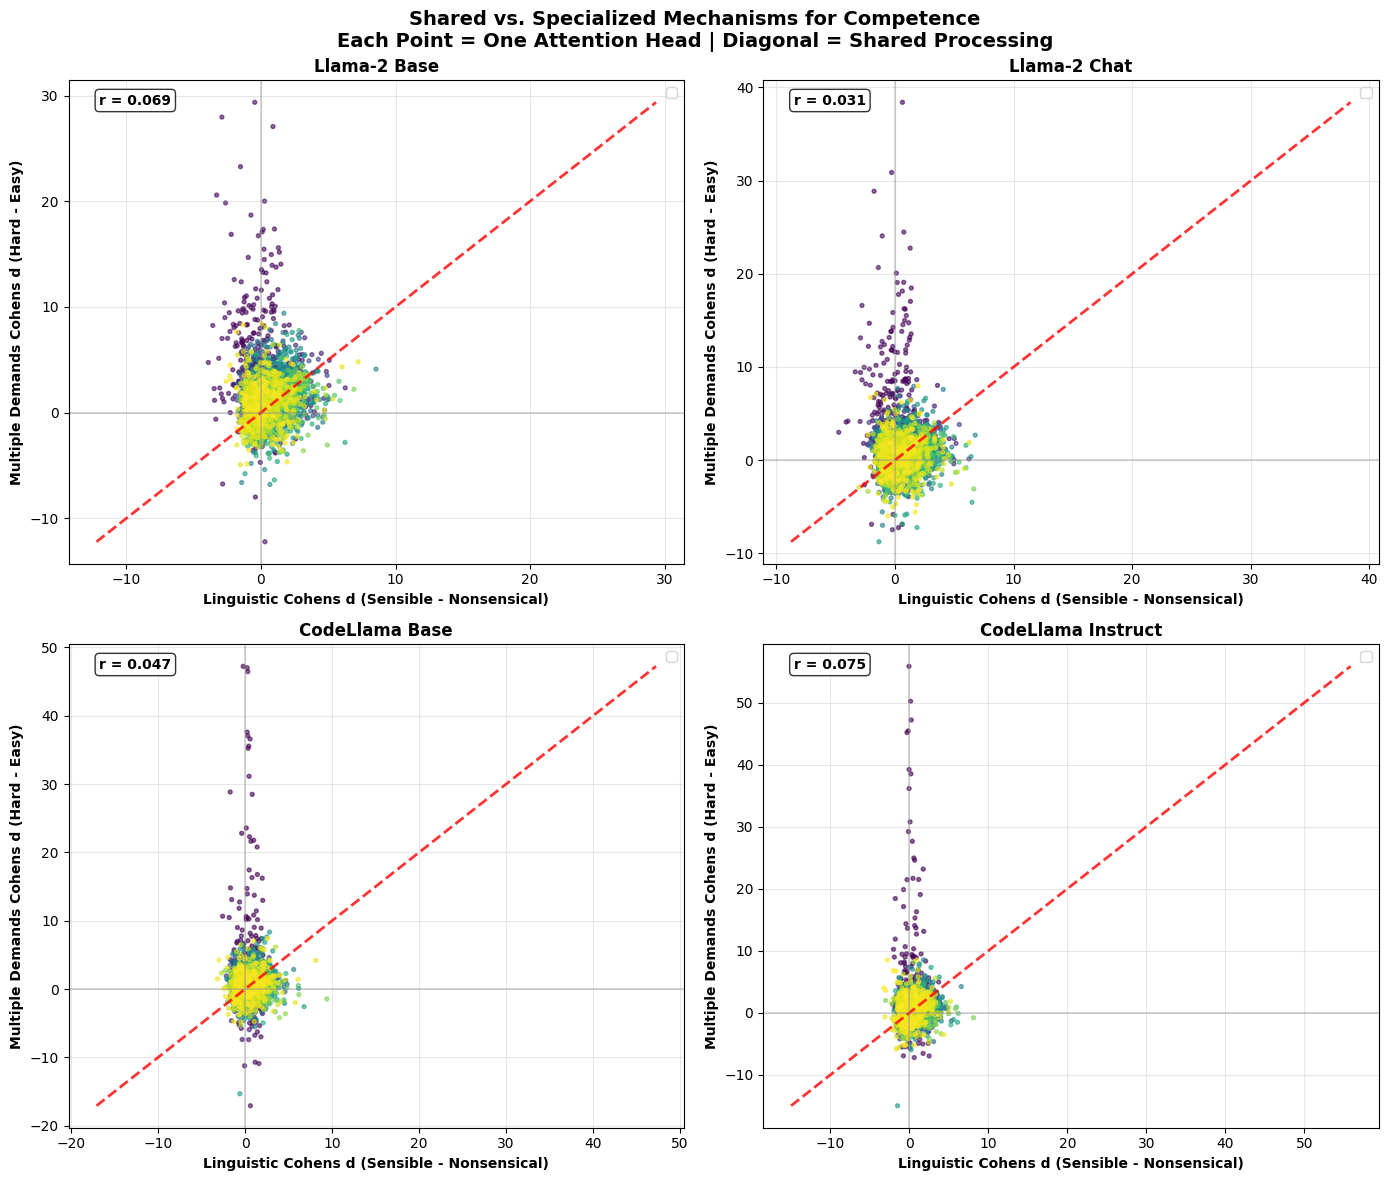


FIGURE 5 KEY FINDINGS (RQ2)

Correlation Analysis (Shared vs. Specialized Processing):
--------------------------------------------------
Llama-2 Base         r = +0.069
Llama-2 Chat         r = +0.031
CodeLlama Base       r = +0.047
CodeLlama Instruct   r = +0.075

Realistic Head Distribution (% of ALL heads):
------------------------------------------------------------
Model                Inactive Ling   MD     Shared
------------------------------------------------------------
Llama-2 Base          20.0% |  2.2% |  6.2% | 71.6%
Llama-2 Chat          20.5% |  2.9% |  5.6% | 71.0%
CodeLlama Base        22.3% |  2.6% |  5.9% | 69.2%
CodeLlama Instruct    20.9% |  2.9% |  6.1% | 70.0%

- RQ2 Answer: Average correlation = 0.055
   • SPECIALIZED processing: Distinct heads for different domains
   • Evidence for domain-specific attention mechanisms
   • Most heads (20.9%) are inactive for complexity processing


In [33]:
# Figure 5: Shared vs Specialized Mechanisms (RQ2)

def create_figure_5_rq2_scatter():
    """
    Creates Figure 5: Scatter plots addressing RQ2
    Shows whether models use shared or specialized attention mechanisms
    """
    
    models = ['Llama-2 Base', 'Llama-2 Chat', 'CodeLlama Base', 'CodeLlama Instruct']
    model_paths = {
        'Llama-2 Base': 'llama_2_70b_base',
        'CodeLlama Base': 'codellama_70b',
        'CodeLlama Instruct': 'codellama_instruct_70b',
        'Llama-2 Chat': 'llama_chat_70b'
    }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    correlations = []
    specialization_metrics = []
    
    for idx, model_name in enumerate(models):
        model_path = model_paths[model_name]
        
        try:
            # Load weighted entropy data for both tasks
            # Linguistic task
            ling_sensible = np.load(f"entropy_results_{model_path}_ling/sensible_weighted_entropy.npy")
            ling_nonsensical = np.load(f"entropy_results_{model_path}_ling/nonsensical_weighted_entropy.npy")
            
            # Multiple Demands task  
            md_easy = np.load(f"entropy_results_{model_path}_md/easy_weighted_entropy.npy")
            md_hard = np.load(f"entropy_results_{model_path}_md/hard_weighted_entropy.npy")
            
            # Calculate Cohen's d for each task
            ling_cohens_d = calculate_cohens_d(ling_sensible, ling_nonsensical)
            md_cohens_d = calculate_cohens_d(md_easy, md_hard)
            
            # Flatten to get one point per attention head
            ling_d_flat = ling_cohens_d.flatten()
            md_d_flat = md_cohens_d.flatten()
            
            # Create scatter plot
            scatter = axes[idx].scatter(ling_d_flat, md_d_flat, alpha=0.6, s=8, 
                                     c=np.arange(len(ling_d_flat)), cmap='viridis')
            
            # Add diagonal line (y = x) to show shared processing
            lim_min = min(np.min(ling_d_flat), np.min(md_d_flat))
            lim_max = max(np.max(ling_d_flat), np.max(md_d_flat))
            axes[idx].plot([lim_min, lim_max], [lim_min, lim_max], 'r--', alpha=0.8, linewidth=2)
            
            # Add axes lines at zero
            axes[idx].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            axes[idx].axvline(x=0, color='gray', linestyle='-', alpha=0.3)
            
            axes[idx].set_xlabel('Linguistic Cohens d (Sensible - Nonsensical)', fontweight='bold')
            axes[idx].set_ylabel('Multiple Demands Cohens d (Hard - Easy)', fontweight='bold')
            axes[idx].set_title(f'{model_name}', fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend()
            
            # Calculate correlation coefficient
            correlation = np.corrcoef(ling_d_flat, md_d_flat)[0, 1]
            correlations.append(correlation)
            
            # Calculate specialization metrics
            # Heads specialized for linguistic (high ling, low md)
            ling_specialized = np.sum((np.abs(ling_d_flat) > 0.3) & (np.abs(md_d_flat) < 0.1))
            # Heads specialized for MD (high md, low ling)
            md_specialized = np.sum((np.abs(md_d_flat) > 0.3) & (np.abs(ling_d_flat) < 0.1))
            # Shared heads (high in both)
            shared = np.sum((np.abs(ling_d_flat) > 0.3) & (np.abs(md_d_flat) > 0.3))
            
            # Calculate percentages relative to ALL heads
            total_heads = len(ling_d_flat)  # All heads in the model
            total_active = ling_specialized + md_specialized + shared
            inactive_heads = total_heads - total_active
            
            ling_spec_pct = (ling_specialized / total_heads) * 100
            md_spec_pct = (md_specialized / total_heads) * 100
            shared_pct = (shared / total_heads) * 100
            inactive_pct = (inactive_heads / total_heads) * 100
            
            specialization_metrics.append({
                'model': model_name,
                'correlation': correlation,
                'ling_specialized': ling_spec_pct,
                'md_specialized': md_spec_pct,
                'shared': shared_pct,
                'inactive': inactive_pct,
                'total_heads': total_heads,
                'total_active': total_active
            })
            
            # Add text annotation with correlation
            axes[idx].text(0.05, 0.95, f'r = {correlation:.3f}', 
                         transform=axes[idx].transAxes, fontweight='bold',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            
            print(f"✓ {model_name}: Correlation = {correlation:.3f}")
            
        except FileNotFoundError as e:
            print(f"Warning: Missing data for {model_name}: {e}")
            # Create dummy scatter plot
            n_points = 5120  # 80 layers * 64 heads
            dummy_ling = np.random.normal(0, 0.3, n_points)
            dummy_md = np.random.normal(0, 0.3, n_points)
            
            axes[idx].scatter(dummy_ling, dummy_md, alpha=0.6, s=8)
            axes[idx].set_xlabel('Linguistic Cohens d (Sensible - Nonsensical)', fontweight='bold')
            axes[idx].set_ylabel('Multiple Demands Cohens d (Hard - Easy)', fontweight='bold')
            axes[idx].set_title(f'{model_name} (Dummy Data)', fontsize=12, fontweight='bold')
            axes[idx].grid(True, alpha=0.3)
            
            correlations.append(0)
            specialization_metrics.append({
                'model': model_name,
                'correlation': 0,
                'ling_specialized': 0,
                'md_specialized': 0,
                'shared': 0,
                'inactive': 100,
                'total_heads': 0,
                'total_active': 0
            })
    
    # Overall figure title
    fig.suptitle('Shared vs. Specialized Mechanisms for Competence\n' +
                 'Each Point = One Attention Head | Diagonal = Shared Processing', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    # Analysis and reporting
    print("\n" + "=" * 60)
    print("FIGURE 5 KEY FINDINGS (RQ2)")
    print("=" * 60)
    
    print("\nCorrelation Analysis (Shared vs. Specialized Processing):")
    print("-" * 50)
    for metric in specialization_metrics:
        print(f"{metric['model']:<20} r = {metric['correlation']:+.3f}")
    
    print("\nRealistic Head Distribution (% of ALL heads):")
    print("-" * 60)
    print(f"{'Model':<20} {'Inactive':<8} {'Ling':<6} {'MD':<6} {'Shared':<6}")
    print("-" * 60)
    for metric in specialization_metrics:
        print(f"{metric['model']:<20} {metric['inactive']:5.1f}% | {metric['ling_specialized']:4.1f}% | " +
              f"{metric['md_specialized']:4.1f}% | {metric['shared']:4.1f}%")
    
    avg_correlation = np.mean(correlations)
    print(f"\n- RQ2 Answer: Average correlation = {avg_correlation:.3f}")
    
    if avg_correlation > 0.5:
        print("   • SHARED processing: Same heads handle both cognitive domains")
        print("   • Evidence for general-purpose attention mechanisms")
    elif avg_correlation < 0.2:
        print("   • SPECIALIZED processing: Distinct heads for different domains")
        print("   • Evidence for domain-specific attention mechanisms")
        print(f"   • Most heads ({np.mean([m['inactive'] for m in specialization_metrics]):.1f}%) are inactive for complexity processing")
    else:
        print("   • MIXED processing: Combination of shared and specialized mechanisms")
        print("   • Evidence for both general and domain-specific processing")
    
    return fig, specialization_metrics

# Execute Figure 5
print("Creating Figure 5: Shared vs. Specialized Mechanisms (RQ2)...")
fig5, rq2_metrics = create_figure_5_rq2_scatter()
